<font color='red'>注：1-3节的处理和实验一模一样，其中打印输出内容删除了，留下了必要的数据处理过程</font><br>
<font color='red'>注：更改第四节的统计分析</font>

### 环境

In [1]:
#导包
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import sys
import math
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Lasso,LogisticRegression,Ridge
from sklearn.metrics import mean_squared_error
import graphviz
from graphviz import Source

mpl.rcParams['font.sans-serif'] = ['simsun']
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#python 版本
print(sys.version)
#各种包版本
!pip list

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Package                            Version
---------------------------------- -------------------
absl-py                            0.11.0
alabaster                          0.7.12
alembic                            1.5.7
anaconda-client                    1.7.2
anaconda-navigator                 1.9.12
anaconda-project                   0.8.3
argh                               0.26.2
asn1crypto                         1.3.0
astroid                            2.4.2
astropy                            4.0.1.post1
astunparse                         1.6.3
atomicwrites                       1.4.0
attrs                              19.3.0
autopep8                           1.5.3
Babel                              2.8.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bc

### 读取数据

In [3]:
#_NASE_PATH存放数据的文件夹
_BASE_PATH = r'D:/DM/'
# _BASE_PATH = r'E:\python\data\成绩数据'

jupyter-console                    6.1.0
jupyter-contrib-core               0.3.3
jupyter-contrib-nbextensions       0.5.1
jupyter-core                       4.6.3
jupyter-highlight-selected-word    0.2.0
jupyter-latex-envs                 1.4.6
jupyter-nbextensions-configurator  0.4.1
jupyterlab                         2.1.5
jupyterlab-server                  1.2.0
Keras                              2.4.3
Keras-Preprocessing                1.1.2
keyring                            21.2.1
kiwisolver                         1.2.0
lazy-object-proxy                  1.4.3
libarchive-c                       2.9
lightgbm                           3.0.0
llvmlite                           0.33.0+1.g022ab0f
locket                             0.2.0
loguru                             0.5.3
lxml                               4.5.2
Mako                               1.1.4
Markdown                           3.3.3
MarkupSafe                         1.1.1
matplotlib                         3.2.2
mccab

In [4]:
#文件路径
files_path = [os.path.join(_BASE_PATH, path) for path in os.listdir(_BASE_PATH)]
#读取数据
data = [pd.read_excel(file_path) for file_path in files_path]
#合并数据
data = pd.concat(data,ignore_index=True)

### 数据清洗

#### 删除不相关列
序号列并无实际意义，直接删除

In [5]:
drop_columns = ['序号']
data.drop(drop_columns,axis=1, inplace=True)

#### 删除无用的行

<font face='宋体'>从上面可以看出学号中'<b>学号</b>'是错误的项，将其索引出来查看是什么</font>

<font face='宋体'>索引出来后，发现是重复的表头，可以直接删掉</font>

In [6]:
data.drop(index=data[data['学号']=='学号'].index,axis=0, inplace=True)
data[data['学号']=='学号']

Empty DataFrame
Columns: [学号, 开课学期, 班级名称, 课程号, 课程名称, 总成绩, 成绩标志, 课程性质, 课程属性, 学时, 学分, 开课单位, 录入人, 考试性质, 补重学期, 备注, 姓]
Index: []

#### 删除重复行

统计重复行

In [7]:
data.duplicated(keep=False).sum()

37512

删除重复行

In [8]:
data = data.drop_duplicates(subset=data.columns,ignore_index=True)


#### 处理缺失值
<hr style="border: .5px solid #ccc;">

1. <font face='宋体'>通过info查看每列的信息</font>
2. <font face='宋体'>通过isna函数统计缺失个数</font>
3. <font face='宋体'>查看具有缺失值的列，找出缺失值的可能原因</font>
4. <font face='宋体'>使用合理的方法填充缺失值</font>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23062 entries, 0 to 23061
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   学号      23062 non-null  object
 1   开课学期    23062 non-null  object
 2   班级名称    23062 non-null  object
 3   课程号     23062 non-null  object
 4   课程名称    23062 non-null  object
 5   总成绩     23062 non-null  object
 6   成绩标志    144 non-null    object
 7   课程性质    21784 non-null  object
 8   课程属性    23062 non-null  object
 9   学时      23062 non-null  object
 10  学分      23062 non-null  object
 11  开课单位    23062 non-null  object
 12  录入人     23060 non-null  object
 13  考试性质    23062 non-null  object
 14  补重学期    976 non-null    object
 15  备注      2722 non-null   object
 16  姓       23062 non-null  object
dtypes: object(17)
memory usage: 3.0+ MB


#### 过滤数据
过滤出需要的数据，即：<b>考试性质只考虑“正常考试”（即只考虑初修成绩）和专业课</b>

##### 选择课程名称作为课程的标识
通过统计发现，虽然课程名称相同，但是课程号却是不同的，
我也不知道这里不同课程号课程会有什么区别，
这里为了方便起见，
假设课程名称相同，课程是一样的，<b>以课程名称为主，不使用课程号</b>

##### 对课程性质进行统一
又通过统计发现，相同课程名称，课程属性却不同的

即使 '班级名称','课程名称','开课学期','课程号' 都相同，仍然有许多课程的 '课程性质' 不同，这说明课程性质数据存在很大不一致现象

In [10]:
#通过groupby_col对data进行分租，统计每print_col是否为相同值，不同的进行输出，extra_col额外展示的列，is_display是否需要打印
def diff(data,groupby_col, print_col,extra_col=[],is_display=False):
    '''
    对数据进行分组，输出每组中 指定列 值不统一的分组及其相关信息

    Parameters
    ----------
    data : DataFranme
        需要统计的输入数据
    groupby_col: List
        数据data中的分组标志
    print_col : str
        统计的列，如果每组中该列的值不一样，则会输出该组
        该值必须属于data.columns
    extra_col : List, default []
        需要额外统计展示的列
    is_display : bool, default False
        是否打印出结果
        .. versionadded:: 0.0.0

    Returns
    -------
    dict
        返回字典，{分组标志值:每组中print_col中的值}
        只返回print_col为多个的值 
    '''
    diff_col = {}
    for c,df in data.groupby(groupby_col):
        #unique每组中print_col的去重值
        unique = df[print_col].unique()
        if unique.shape[0]>1:#过滤print_col值不一样个数少于2的
            diff_col[c] = unique.tolist()
            if is_display:
                print(c, '\t', unique, '\t',*[df[col].unique() for col in extra_col])
    return diff_col
# _ = diff(data,['班级名称','课程名称','开课学期','课程号'],'课程性质',[], True)


以课程名称为分组列，同一名称的课程按以下优先级顺序进行统一<br>
专业课 专业任选课 实践性环节 工程基础课 学科平台基础课程 学科基础课 公共基础课 公共课 公共任选课 通识教育基础课程 通识教育课程 其他<br>
特例：如果课程名称中含有 '校公选' 则直接认为是 公共任选课

In [11]:
#课程性质 不统一的 课程
diff_dict = diff(data,['课程名称'],'课程性质')

#applay回调函数 对课程性质进行统一
def call_func(x):
    global diff_dict
    # 优先级列表，越靠前，越优先选取
    priority = ['专业课', '专业任选课', '实践性环节', '工程基础课', '学科平台基础课程', '学科基础课', '通识教育基础课程', '通识教育课程' ,'公共基础课', '公共课', '公共任选课', '其他', np.nan]
    course_name = x['课程名称']
    #课程名称含有校公选 为特例
    if '校公选' in course_name:
        x['课程性质'] = '公共任选课'
    elif x['课程名称'] in diff_dict:
        name = np.nan
        for course_name in diff_dict[x['课程名称']]:
            if priority.index(course_name) < priority.index(name):
                name = course_name
        x['课程性质'] = name
    return x
data = data.apply(call_func,axis=1)
_ = diff(data,['课程名称'],'课程性质',[],True)

##### 过滤出初修成绩
通过统计发现， 当'<b>班级名称</b>','<b>课程名称</b>','<b>学号</b>'都相同时，但是会出现多条记录，这是由于刷分、重修、缓考或者补考等现象导致，所以需要进行逐一处理，得到初修成绩

In [12]:
#分组标志列
mark_col = ['班级名称','课程名称','课程号','学号','开课学期','课程性质']
# _ = diff(data,mark_col,'总成绩',['成绩标志','学时','学分','开课单位','录入人','考试性质','补重学期','备注'], True)

a. 如果 考试性质 不是 正常考试和补考一 则数据一定不是初修成绩，所以直接过滤重修

In [13]:
data['考试性质'].unique()

array(['重修一', '正常考试', '补考一'], dtype=object)

In [14]:
#选取正常考试和补考一的，补考也是初修成绩
data = data[(data['考试性质']=='正常考试') | (data['考试性质']=='补考一')]

去掉之后仍然有多条记录的的，

b. 计算机冲抵不属于初修，删掉

In [15]:
data = data[~(data['备注'].str.find('计算机冲抵')>-1)]

剩余重复都是，缓考，补考缺考的记录导致，缓考、补考算初修，选初次与补考最大值，补考时缺考算第一次的值，因为补考缺考是0，所以直接取最大值

补重学期时间比开课时间大的属于重修 删掉重修<br>
c. 例如开课学期为 2015-2016-1 补重学期 为 2015-2016-1则是补考，如果补重学期为2016-2017-1则为重修考试

In [16]:
#apply回调函数 对补重学期重新编码，0为空，1为补考，2为重修考试
def call_func(x):
    if type(x['补重学期'])== str:
        y1 = int(x['开课学期'].split('-')[0])
        y2 = int(x['补重学期'].split('-')[0])
        if(y1==y2):
            x['补重学期'] = 1
        else:
            x['补重学期'] = 2
    else:
        x['补重学期'] = 0
    return x
data = data.apply(call_func,axis=1)

In [17]:
#删掉重修的
data.drop(index=data[data['补重学期']==2].index,inplace=True)

剩余中出现多条记录是由于缺考、补考、缓考导致,他们都是初修的成绩<br>
d. 删除备注为缺考的行，缺考的分数是0，值是最小的

In [18]:
#删除备注含有缺考的
d_note = data[data.duplicated(mark_col,keep=False)]
_index = d_note[d_note['备注'].str.find('缺考')>-1].index
data.drop(index=_index,inplace=True)

In [19]:
_data = data.drop(columns='补重学期')
d_note = data[_data.duplicated(mark_col,keep=False)]
d_note = d_note.reset_index()
d_note = d_note.set_index(mark_col)
_index = d_note[(d_note['补重学期'] == 1)].index
dd = d_note.loc[_index]
index = dd[dd['补重学期']==0]['index']
index = index.reset_index(drop=True)
data.drop(index=index.values.tolist(),axis=1,inplace=True)

In [20]:
_data = data.drop(columns='补重学期')
d_note = data[_data.duplicated(mark_col,keep=False)]
data.drop(index=d_note[~((d_note['备注'].str.find('考')>-1) | (d_note['备注'].str.find('+')>-1))].index,inplace=True)

e. 剩下缓考，删除为总成绩0的

In [21]:
_d =diff(data,mark_col,'总成绩',['备注'], True)

('10404071', '关系数据库管理系统', '04040154a', '1040407128', '2011-2012-1', '其他') 	 ['0' '80'] 	 ['缓考' '缓考原80']


In [22]:
d_note = data[data.duplicated(mark_col,keep=False)]
data.drop(index=(d_note['总成绩']==0).index,inplace=True)

In [23]:
data.shape

(22034, 17)

##### 成绩转化
将部分'<b>总成绩</b>'的优、良、中、及格、不及格转化为分别对应95、85、75、65、45 计算机等级考试的 '优':95,'良':85,'不通过':45,'通过':70,'合格':70

In [24]:
def switch(x):
    score = {'优':95,'良':85,'中':75,'及格':65,'不及格':45,'不通过':45,'通过':70,'合格':70}
    if x in score:
        return score[x]
    else:
        return x
data['总成绩'] = data['总成绩'].map(switch)
data['总成绩'] = data['总成绩'].astype(np.float)


<!-- <font face='宋体'>没有缺失值</font> -->
### 统计分析

#### 特征工程1

In [25]:
Englis = data[data['课程名称'].astype(str).str.find('全国大学生英语')>-1] #找到四六级数据
CET_4 = Englis[data['课程名称'].astype(str).str.find('四')>-1] #找到四级数据
CET_6 = Englis[data['课程名称'].astype(str).str.find('六')>-1] #找到六级数据
college_English = data[data['课程名称'].astype(str).str.find('英语')>-1] #找到英语课成绩

#####接下来将CET-4、CET-6、大学英语课程数据按学号分组，取出每个人的数据
s_tu4 = {}
for n, cet4 in  CET_4.groupby(by='学号'):
    score = cet4['总成绩'].max()
    if score == 0:
        continue
    s_tu4[n] = score
s_tu6 = {}
for n, cet6 in  CET_6.groupby(by='学号'):
    score = cet6['总成绩'].max()
    if score == 0:
        continue
    s_tu6[n] = score

C_E = {}
for n, ce in  college_English.groupby('学号'):
    score = ce['总成绩'].mean()
    if score == 0:
        continue
    C_E[n] = score
#将得到的数据转为Series
CET_4 = pd.Series(s_tu4)
CET_6 = pd.Series(s_tu6)
C_E = pd.Series(C_E)

In [26]:
#过滤掉英语四六级，计算机等级考试等
data = data[data['课程名称'].str.find('全国')<=-1]
data = data[data['课程名称'].str.find('校公')<=-1]
#获得每个人的届
data['班级名称'] = data['班级名称'].astype(str)
data['届'] = data['班级名称'].str[0:2]


In [31]:
group_data = data.groupby('届')
#存储每届数据
ninety_rank = {}
for ninety, ninety_data in group_data:
    ninety_rank[ninety] = ninety_data.groupby('学号')['总成绩','姓'].agg(
    {'总成绩':[lambda x: (x<60).sum(),#计算每个人的挂科数
        lambda x: x.shape[0],          #计算每个人所选课程数目
      lambda x:x[(x>=90)].shape[0],    #计算每个人90分以上课程数
      lambda x:x[(x<90) & (x>=80)].shape[0],      #计算每个人80-90分以上课程数
      lambda x:x[(x<80) & (x>=70)].shape[0],      #计算每个人70-80分以上课程数
      lambda x:x[(x<70) & (x>=60)].shape[0],      #计算每个人60-70分以上课程数
      'mean','std']         ##计算每个人平均分和标准差
    })
#添加第几届
for ninety in ninety_rank:
    ninety_rank[ninety]['届'] = ninety
    
# 将数据转化为DataFrame
ninety_rank = pd.concat(list(ninety_rank.values()))
#重命名列名
ninety_rank.columns = ['挂科数','课程数','优','良','中','一般','mean','std','届']
#ninety_rank_data回归使用，ninety_rank聚类使用
ninety_rank_data = ninety_rank.copy()

#将 '挂科数','优','良','中','一般' 转化为比率
cols = ['挂科数','优','良','中','一般']
for col in cols:
    ninety_rank[col] = ninety_rank[col]/ninety_rank['课程数']


In [32]:
#ninety_rank_data 添加CET_4、CET_6、C_E数据，回归时使用
#C_E_ 0表示大学英语成绩丢失，CET_4_ 0表示没有参加过CET-4考试、CET_6_ 0表示没有参加过CET-6考试
ninety_rank_data['CET_4'] = CET_4
ninety_rank_data['CET_6'] = CET_6
ninety_rank_data['C_E'] = C_E
ninety_rank_data['CET_4'].fillna(0,inplace=True)
ninety_rank_data['CET_4_'] = ninety_rank_data['CET_4'].map(lambda x:0 if x == 0 else 1)
ninety_rank_data['CET_6'].fillna(0,inplace=True)
ninety_rank_data['CET_6_'] = ninety_rank_data['CET_6'].map(lambda x:0 if x == 0 else 1)
ninety_rank_data['C_E'].fillna(0,inplace=True)
ninety_rank_data['C_E_'] = ninety_rank_data['C_E'].map(lambda x:0 if x == 0 else 1)

In [33]:
#计算学分绩点
score_dict = {}
for s_number, s_data in data.groupby('学号'):
    score = (s_data['总成绩'].astype(float)-50)/10*s_data['学分'].astype(float)
    score[score<0] = 0
    score = score.sum()/s_data['学分'].astype(float).sum().tolist()
    score_dict[s_number]=(score)
    
ninety_rank['绩点'] = pd.Series(score_dict)
ninety_rank_data['绩点'] = pd.Series(score_dict)

ninety_rank

挂科数   课程数         优         良         中        一般  \
学号                                                                     
0840407202    0.102564  39.0  0.051282  0.307692  0.358974  0.179487   
0940407122    0.050000  40.0  0.025000  0.225000  0.500000  0.200000   
0940407125    0.050000  40.0  0.050000  0.325000  0.350000  0.225000   
0940407131    0.117647  34.0  0.088235  0.264706  0.352941  0.176471   
1040407101    0.000000  47.0  0.276596  0.468085  0.255319  0.000000   
...                ...   ...       ...       ...       ...       ...   
162210409235  0.000000  45.0  0.155556  0.400000  0.200000  0.244444   
162210409236  0.000000  47.0  0.531915  0.361702  0.085106  0.021277   
162210503101  0.000000  49.0  0.204082  0.551020  0.224490  0.020408   
162210503201  0.000000  46.0  0.304348  0.391304  0.282609  0.021739   
162210710117  0.136364  44.0  0.068182  0.318182  0.227273  0.250000   

                   mean        std   届        绩点  
学号                                                
0840407202    73.128205  12.513528  10  2.045924  
0940407122    72.275000  12.430293  10  2.140802  
0940407125    73.475000  16.076719  10  2.647402  
0940407131    71.323529  18.828928  10  2.068858  
1040407101    84.531915   8.644805  10  3.639205  
...                 ...        ...  ..       ...  
162210409235  78.844444   9.999899  16  2.644189  
162210409236  87.978723   7.803258  16  3.799373  
162210503101  83.734694   7.126171  16  3.361585  
162210503201  84.043478   8.082784  16  3.321429  
162210710117  68.363636  22.190602  16  2.167478  

[464 rows x 10 columns]

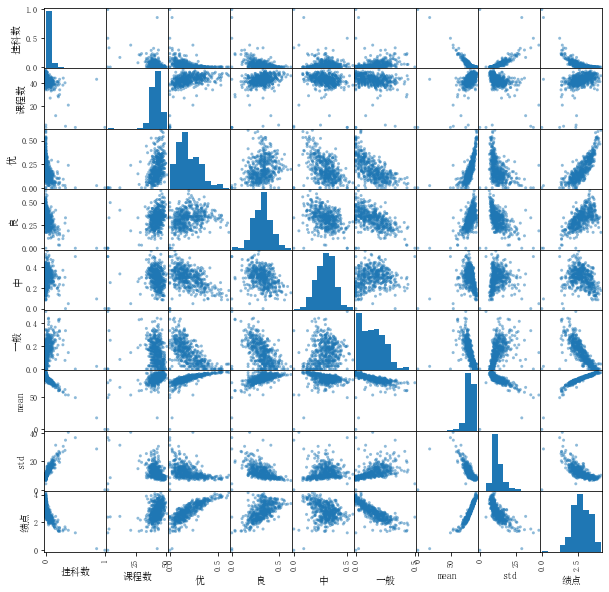

挂科数       课程数         优         良         中        一般      mean  \
挂科数   1.000000 -0.525465 -0.409917 -0.505545 -0.126889  0.253342 -0.915670   
课程数  -0.525465  1.000000  0.389009  0.329403 -0.105175 -0.252834  0.558684   
优    -0.409917  0.389009  1.000000  0.256708 -0.505752 -0.660497  0.685106   
良    -0.505545  0.329403  0.256708  1.000000 -0.328685 -0.571002  0.609052   
中    -0.126889 -0.105175 -0.505752 -0.328685  1.000000  0.156806 -0.119765   
一般    0.253342 -0.252834 -0.660497 -0.571002  0.156806  1.000000 -0.539427   
mean -0.915670  0.558684  0.685106  0.609052 -0.119765 -0.539427  1.000000   
std   0.657161 -0.403833 -0.453078 -0.525528  0.022991  0.482754 -0.669498   
绩点   -0.709276  0.434962  0.825544  0.614119 -0.246074 -0.776384  0.895367   

           std        绩点  
挂科数   0.657161 -0.709276  
课程数  -0.403833  0.434962  
优    -0.453078  0.825544  
良    -0.525528  0.614119  
中     0.022991 -0.246074  
一般    0.482754 -0.776384  
mean -0.669498  0.895367  
std   1.000000 -0.705237  
绩点   -0.705237  1.000000

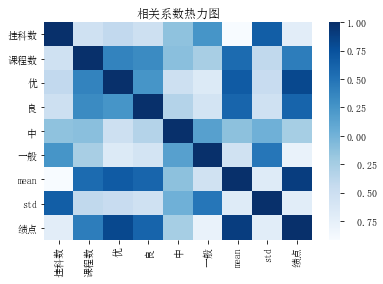

In [34]:
# cmap = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
#散点图矩阵
pd.plotting.scatter_matrix(ninety_rank,figsize=(10,10))
plt.show()
#相关性矩阵
display(ninety_rank.corr())
axes = sns.heatmap(ninety_rank.corr(),cmap='Blues')
axes.set_title('相关系数热力图')
plt.show()

#### 特征工程2 -聚类

In [35]:
#kmeans聚类
kmeans = KMeans(n_clusters=3,random_state=2021)
kmeans.fit(ninety_rank)
#保存类别
ninety_rank_data['kmeans']=kmeans.labels_

In [36]:
#使用TSNE降维，对聚类进行可视化
tsne = TSNE(random_state=2021)
tsne.fit_transform(ninety_rank[[i for i in ninety_rank.columns if i not in ['姓']]])
tsne=pd.DataFrame(tsne.embedding_,index=ninety_rank.index)

Text(0.5, 1.0, '聚类可视化T-SNE')

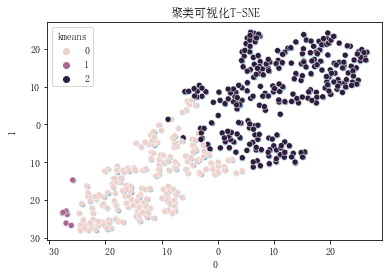

In [37]:
tsne.plot(kind='scatter', x=0,y=1)
axes = sns.scatterplot(x=tsne[0],y=tsne[1],hue=ninety_rank_data['kmeans'])
axes.set_title('聚类可视化T-SNE')

In [38]:
ninety_rank_data[ninety_rank_data['kmeans']==0]

挂科数   课程数    优     良     中    一般       mean        std   届  \
学号                                                                         
0840407202    4.0  39.0  2.0  12.0  14.0   7.0  73.128205  12.513528  10   
0940407122    2.0  40.0  1.0   9.0  20.0   8.0  72.275000  12.430293  10   
0940407125    2.0  40.0  2.0  13.0  14.0   9.0  73.475000  16.076719  10   
0940407131    4.0  34.0  3.0   9.0  12.0   6.0  71.323529  18.828928  10   
1040407104    2.0  38.0  2.0  10.0  15.0   9.0  73.157895  13.062276  10   
...           ...   ...  ...   ...   ...   ...        ...        ...  ..   
162210409135  2.0  39.0  2.0  11.0   8.0  16.0  71.974359  13.125883  16   
162210409210  6.0  41.0  5.0   8.0   9.0  13.0  68.487805  20.171914  16   
162210409231  1.0  45.0  6.0  10.0  14.0  14.0  74.400000  13.467807  16   
162210409233  1.0  46.0  2.0  13.0  17.0  13.0  74.304348  12.212688  16   
162210710117  6.0  44.0  3.0  14.0  10.0  11.0  68.363636  22.190602  16   

              CET_4  CET_6         C_E  CET_4_  CET_6_  C_E_        绩点  kmeans  
学号                                                                              
0840407202    435.0  348.0  226.142857       1       1     1  2.045924       0  
0940407122    436.0  326.0  311.000000       1       1     1  2.140802       0  
0940407125    457.0  351.0  303.200000       1       1     1  2.647402       0  
0940407131    428.0    0.0  360.333333       1       0     1  2.068858       0  
1040407104    442.0  428.0  268.750000       1       1     1  2.363636       0  
...             ...    ...         ...     ...     ...   ...       ...     ...  
162210409135    0.0    0.0   61.000000       0       0     1  1.924396       0  
162210409210    0.0    0.0   61.000000       0       0     1  1.671280       0  
162210409231    0.0    0.0   73.000000       0       0     1  2.217012       0  
162210409233    0.0    0.0   77.000000       0       0     1  2.166486       0  
162210710117  458.0    0.0  136.500000       1       0     1  2.167478       0  

[190 rows x 17 columns]

#### 回归模型

In [39]:
#回归模型训练
def train(model,data,cols,target,n_splits=40):
    print(target)
    KF = KFold(n_splits=n_splits,shuffle=True,random_state=None)
    MSE = []
    for train_index, test_index in KF.split(data):
        X = data[cols]
        y = data[target]
        X_train,X_test,y_train,y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
        model.fit(X_train,y_train)
        y_pre = model.predict(X_test)
        mse = mean_squared_error(y_pre,y_test)
        MSE.append(mse)
    print(f'平均均方误差为：{sum(MSE)/n_splits}')


In [40]:
# 预测CET-4

#cols  X列
cols = [i for i in ninety_rank_data.columns if i not in ['CET_4','CET_6','CET_6_']] 
# 目标列
target = 'CET_4'
n_splits=40
####决策树
arg = {
        'criterion':'mae',
        'splitter':'best',
        'max_depth':3,
        'min_samples_split':2,
        'min_samples_leaf':3,
        'max_features':None,
        'random_state':None,
        'max_leaf_nodes':5,
    }
tree = DecisionTreeRegressor(**arg)

#随机森林
arg = {
    'n_estimators':30,
    'criterion':'mae',
    'max_depth':4,
    'min_samples_split':2,
    'min_samples_leaf':3,
    'max_features':None,
    'random_state':None,
    'max_leaf_nodes':5,
}
RF = RandomForestRegressor(**arg)

#Lasso回归
lasso = Lasso(alpha=1)

#逻辑回归
arg={
    'penalty':'l2',
    'l1_ratio':0.1,
    'C':1.0,
}
logistic = LogisticRegression(**arg)

#岭回归
ridge = Ridge(alpha=0.5)

#支持向量机
# svr = SVR()


models =[tree,RF,lasso,logistic,ridge]
for model in models:
    train(model,ninety_rank_data,cols,target,n_splits=n_splits)


CET_4
平均均方误差为：2178.6645833333337
CET_4
平均均方误差为：1887.2830731797137
CET_4
平均均方误差为：1772.275776377491
CET_4
平均均方误差为：3066.179924242424
CET_4
平均均方误差为：1784.8752696482031
CET_4
平均均方误差为：27313.5844600013


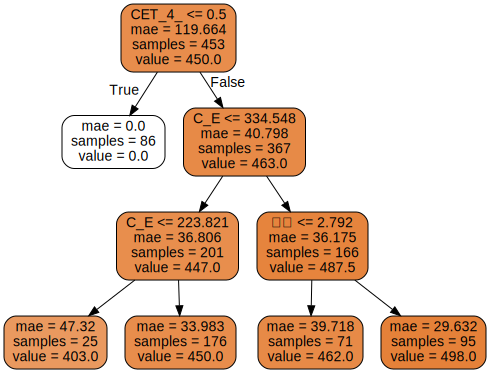

In [41]:
#决策树展示
IMAGES_PATH='./'
export_graphviz(
        tree,
        out_file=os.path.join(IMAGES_PATH, "tree.dot"),
        feature_names=cols,
        class_names=target,
        rounded=True,
        filled=True
    )
Source.from_file(os.path.join(IMAGES_PATH, "tree.dot"))

In [42]:
#预测CET-6

cols = [i for i in ninety_rank_data.columns if i not in ['CET_6']] 
target = 'CET_6'
n_splits=40

####决策树
arg = {
        'criterion':'mse',
        'splitter':'best',
        'max_depth':4,
        'min_samples_split':2,
        'min_samples_leaf':3,
        'max_features':None,
        'random_state':None,
        'max_leaf_nodes':5,
    }
tree = DecisionTreeRegressor(**arg)

#随机森林
arg = {
    'n_estimators':30,
    'criterion':'mse',
    'max_depth':6,
    'min_samples_split':2,
    'min_samples_leaf':3,
    'max_features':None,
    'random_state':None,
    'max_leaf_nodes':8,
}
RF = RandomForestRegressor(**arg)

#Lasso回归
lasso = Lasso(alpha=1)

#逻辑回归
arg={
    'penalty':'l2',
    'l1_ratio':0.1,
    'C':1.0,
}
logistic = LogisticRegression(**arg)

#岭回归
ridge = Ridge(alpha=0.5)

#支持向量机
# svr = SVR(kernel='sigmoid')

models =[tree,RF,lasso,logistic,ridge]
for model in models:
    train(model,ninety_rank_data,cols,target,n_splits=n_splits)


CET_6
平均均方误差为：1777.5474784659102
CET_6
平均均方误差为：1497.466977570686
CET_6
平均均方误差为：1852.9777465016182
CET_6
平均均方误差为：51537.1418560606
CET_6
平均均方误差为：1743.714361571924
CET_6
平均均方误差为：36998.45455276483


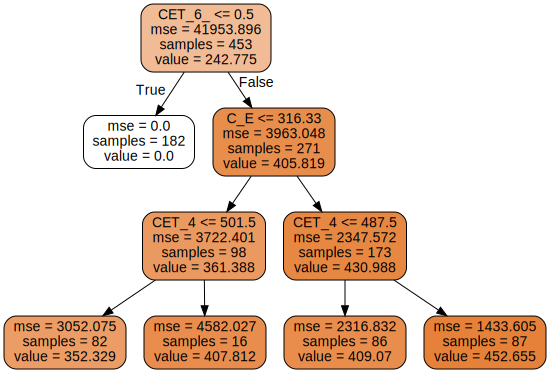

In [78]:
#决策树展示
IMAGES_PATH='./'
export_graphviz(
        tree,
        out_file=os.path.join(IMAGES_PATH, "tree.dot"),
        feature_names=cols,
        class_names=target,
        rounded=True,
        filled=True
    )
Source.from_file(os.path.join(IMAGES_PATH, "tree.dot"))

#### 结论


- 从决策树的结果来看，四级的通过与否主要与绩点和大学英语相关，大学英语成绩越高、绩点越高四级的分数基本也较高
- 六的分数与四级和大学英语直接相关，四级越高、大学英语的成绩越高，六级成绩越高
- <font color='red'>从结果来看，随机森林的效果最好，但是所有模型的均方误差仍然很大，这可能和数据质量有关，比如有小部分人的英语成绩缺失，且大多数人英语成绩不完整(大学英语1,2,3,4)。还有些人课程数据不完整，导致计算相关属性时误差较大</font>